# <h1 style="text-align:center">EDA + Baseline Model  - Sartorius cell segmentation</h1>



* [1. Introduction](#section1)
* [2. Importing libraries](#section2)
* [3. Understanding data](#section3)
* [4. Basic Analysis](#section4)
  * [4.1 Checking for missing values and duplicates](#section4)
  * [4.2 Analysis on cell types](#section6)
* [5. Analysis on images and masks](#section7)
   * [5.1 Basic analysis on images](#section7)
   * [5.2 RLE encoding](#section8)
   * [5.3 Visualizing images and masks](#section9)
* [6. Baseline model](#section10)
   * [6.1 Load data using tf data api](#section11)
   * [6.2 Model](#section12)
   * [6.3 Training](#section13)
   * [6.4 Inference](#section14)
   * [6.5. Test image prediction and submission](#section15)



<img src="https://image.shutterstock.com/image-illustration/3d-illustration-t-cells-cancer-600w-433526728.jpg" height="200px" width="1000px">

  

<a class="anchor" id="section1"></a>
## 1. Introduction



### Understanding business problem

Neurological disorders like Alzheimer's and brain tumors are one of the leading causes of death and disability across the globe. Once a person is opted for treatment, it is very hard to find how the person is responding to treatment. One accepted method for that is to review neuronal cells are viewed via light microscopy. But to segment neuronal cells in microscopic images can be challenging.

Here comes the need of computer vision. Accurate instance segmentation of these cells could lead to new and effective drug discoveries to treat the millions of people with these disorders. So our problem is to **segment the cell present in the microscopic images**. ie, We have an instance segmentation problem.


Note: Current solutions have limited accuracy for neuronal cells in particular. Also it is important to note that cell types like SH-SY5Y consistently exhibits the lowest precision scores. This could be because neuronal cells have a very unique, irregular and concave morphology associated with them, making them challenging to segment with commonly used mask heads. 


<a class="anchor" id="section2"></a>
## 2. Importing libraries


In [ ]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os,random,glob
from collections import Counter
import cv2
import tqdm.notebook as tqdm
plt.style.use('seaborn-whitegrid')

import os,random,glob
from collections import Counter
import cv2
import time
import tqdm.notebook as tqdm

import tensorflow as tf
from tensorflow import keras
import albumentations as A
tf.random.set_seed(42)
import warnings
warnings.simplefilter("ignore")
tf.config.run_functions_eagerly(True)


<a class="anchor" id="section3"></a>
## 3. Understanding data

In [ ]:
MAIN_PATH = '../input/sartorius-cell-instance-segmentation'
CSV_PATH = '../input/sartorius-cell-instance-segmentation/train.csv'
TRAIN_DIR_PATH = '../input/sartorius-cell-instance-segmentation/train'
TEST_DIR_PATH = '../input/sartorius-cell-instance-segmentation/test'

os.listdir(MAIN_PATH)

In [ ]:
df_train = pd.read_csv(CSV_PATH)
print(df_train.shape)
df_train.head()


<b>Train.csv</b> -- This contains ids and rle encoded masks to corresponding ids.


* <b>id</b> : <i>unique identifier for object.</i><br>

* <b>annotation</b> : <i>run length encoded pixels for the identified neuronal cell.</i><br>

* <b>width</b> : <i>source image width.</i><br>

* <b>height</b> : <i>source image height</i> <br>

* <b>cell_type</b> : <i>the cell line.</i><br>

* <b>plate_time</b> : <i>time plate was created.</i><br>

* <b>sample_date</b> : <i>date sample was created.</i><br>

* <b>sample_id</b> : <i>sample identifier.</i> <br>

* <b>elapsed_timedelta</b> : <i>time since first image taken of sample.</i><br>


<b>train and test directory</b> -- This folders contains train and test images for our model

<b>LIVECell_dataset_2021 directory</b> -- This folder contains more images, if we are intrested in transfer learning approach. This is a  mirror of the data from the LIVECell dataset.LIVECell is the predecessor dataset to this competition. 

<b>train_semi_supervised directory</b> -- This folder containe unlabelled data, We can use it if we are doing any semi supervised approach.


<a class="anchor" id="section4"></a>
## 4. Basic Analysis

<a class="anchor" id="section5"></a>
### Checking for missing values and duplicates

Let us check for missing values and duplicate entries.

In [ ]:
#checking for missing values
df_train.isnull().sum()

In [ ]:
df_train[df_train.duplicated()]

* We don't have any missing values. 
* For a single id,we have multiple annotations present. We can understand it further when are visualizing the image


<a class="anchor" id="section6"></a>
## Analysis on cell types

We have diffeent cell types present. Let us see the number of images present in each.

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(df_train['cell_type'])
plt.title('No of images under each cell type')
plt.show()

Let us plot images of various cell types and see there any difference

In [ ]:
def load_image(img_path):
    """
    function to load image
    Args:
        img_path: path to image
    Returns:
        img: image array
       
    """
    
    img_src = cv2.imread(img_path)
    img = cv2.cvtColor(img_src,cv2.COLOR_BGR2RGB)
    return img


In [ ]:
cell_types = list(np.unique(df_train['cell_type']))
for ct in cell_types:
        fig,axes = plt.subplots(1,3,figsize=(20,6))
        df_ct = df_train[df_train['cell_type'] == ct]
        for i,id_ in enumerate(np.unique(df_ct['id'])[0:3]):
            img_path = os.path.join(TRAIN_DIR_PATH,id_+'.png')
            img = load_image(img_path)
            axes[i].imshow(img)

        plt.suptitle(f'Cell type- {ct}')
        plt.show()

From the above microscopic images, we can see the difference in pattern among various cell types. Our objective is to segment these cells from microscopic images.

<a class="anchor" id="section7"></a>

## 5. Analysis On Images and Masks

We have our image id and corresponding rle encoding present in our train.csv.  Let us see the mean of images.

### Basic analysis on images

**No of images in each directory**

In [ ]:
print(f'No of images in train directory: {len(os.listdir(TRAIN_DIR_PATH))}')
print(f'No of images in test directory: {len(os.listdir(TEST_DIR_PATH))}')                                             

**Checking for image shapes**

In [ ]:
def check_shapes(dir_path):
    """
    check for unique image shapes
    """
    img_shapes = []
    for im in os.listdir(dir_path):
        img_path = os.path.join(dir_path,im)
        img = cv2.imread(img_path)
        img_shapes.append(img.shape)
    
    img_shapes = Counter(img_shapes)
    return len(img_shapes), img_shapes
        
len_,shapes_ = check_shapes(TRAIN_DIR_PATH)
print(f'There are {len_} Unique image shapes in train images.They are: {shapes_}')
len_,shapes_ = check_shapes(TEST_DIR_PATH)
print(f'There are  {len_ } Unique image shapes in test images.They are {shapes_}')

So we have all image of shape 520,704,3 





In [ ]:
#sample
path = '../input/sartorius-cell-instance-segmentation/train/04928f0866b0.png'
im = load_image(path)
plt.imshow(im)
plt.show()

In [ ]:

# check the train images
means = []
train_paths = glob.glob(TRAIN_DIR_PATH+'/*')
for im in tqdm.tqdm(train_paths):
    img = load_image(im)
    means.append(img.mean())
print("Train mean: ", np.mean(means))

# check the test images
means = []
test_paths = glob.glob(TEST_DIR_PATH+'/*')
for im in tqdm.tqdm(test_paths):
    img = load_image(im)
    means.append(img.mean())
print("Test mean: ", np.mean(means))


We can see that both train and test images share almost same mean. Let us explore further



<a class="anchor" id="section8"></a>

### RLE Encoding
### What is RLE encoding?

Run-length encoding (RLE) is a form of lossless data compression in which runs of data are stored as a single data value and count, rather than as the original run. Let's understand how to generate masks if EncodedPixels(RLE) is given instead of mask images with an example. Let us take an example, take the image with the following rle:
```
118145 6 118849 7 119553 8 120257.......118145 6 118849 7 119553 8 120257
```
This indicates that if the image is flattened to 1D, starting from 118145 pixel we have 6 pixels for mask. Similarly starting from 118145 pixel we have 7 pixels for mask and this goes on.

Note: It is important to note that corresponding to same image id we have multiple rle indicates multiple cell segments. Also we do not have any image without rle.

Let us try to visualize a mask and image.

In [ ]:
# let us see how run length encoding looks
row = df_train.iloc[0]
rle = row['annotation']
rle[0:100]

<a class="anchor" id="section9"></a>
### Visualizing images and masks

In [ ]:


def rle_decode(rle, img_shape,color=1):
    """
    decode rle and generate mask
    
    Args:
       rle: coded rle
       img_shape: shape of input image
       color: color of the rle
    Returns:
       mask: generated mask
    """
    s = rle.split()
    lengths = list(map(int, s[1::2]))
    starts = list(map(int, s[0::2]))
    ends = [v+lengths[i] for i,v in enumerate(starts)]
    
    msk = np.zeros((img_shape[0] * img_shape[1]), dtype=np.float32)
    for i,v in enumerate(starts):
        msk[v:v+lengths[i]] = color
    
    mask = msk.reshape(img_shape)
    return mask


def build_mask(rles,img_shape):
    """
    Generate mask from multiple encodigs
    Args:
      rles: list of rle
    Returns:
      mask: generated mask
    """
    mask = np.zeros(img_shape)
    for rle in rles:
        mask += rle_decode(rle,img_shape)
    return mask

In [ ]:
img_paths = glob.glob(TRAIN_DIR_PATH+'/*')
idx = random.randint(0,len(img_paths))
img_path = img_paths[idx]
img_id = img_path.split('/')[-1].split('.')[-2]

#create list of rles
df = df_train[df_train['id'] == img_id]
rles = df['annotation'].values
#get image and mask
img = load_image(img_path)
mask = build_mask(rles,img.shape[0:2])
fig,axes = plt.subplots(3,1,figsize=(10,20))
axes[0].imshow(img)
axes[0].set_title('image')
axes[1].imshow(mask,cmap="gray")
axes[1].set_title('mask')
axes[2].imshow(img,cmap='bone')
axes[2].imshow(mask,alpha=0.3,cmap='Reds')
axes[2].set_title('Image Annoted')
plt.show()
    

In [ ]:
def show_image_mask(n,dir_path):
    img_paths = glob.glob(dir_path+'/*')

    for i in range(n):
        #generate random image
        idx = random.randint(0,len(img_paths))
        img_path = img_paths[idx]
        img_id = img_path.split('/')[-1].split('.')[-2]
        #create list of rles
        df = df_train[df_train['id'] == img_id]
        rles = df['annotation'].values
        #get image and mask
        img = load_image(img_path)
        mask = build_mask(rles,img.shape[0:2])
        fig,axes = plt.subplots(1,3,figsize=(15,5))
        axes[0].imshow(img)
        axes[0].set_title('image')
        axes[1].imshow(mask,cmap="gray")
        axes[1].set_title('mask')
        axes[2].imshow(img,cmap='bone')
        axes[2].imshow(mask,alpha=0.3,cmap='Reds')
        axes[2].set_title('Image Annoted')
        plt.suptitle(f'Image id {img_id}')
        plt.show()
    

In [ ]:
show_image_mask(n=5,dir_path=TRAIN_DIR_PATH)

<a class="anchor" id="section10"></a>
# 6. Baseline Model

We will be using tensorflow to create a baseline model. We will begin with a Unet for semantic segmentation. After prediction we can convert it to a semantic segmentation model.


### About business Problem

Actually our objective is to segment each cell present in microscopic image. It is a kind of instance segmentation. But if we are able to do semantic segmentation of whole microscopic image and then we can get each of the cell from it and utimatly proceed towards instance segmentation. So we will train our model to do semantic segmentation from microscopic images.



In [ ]:
print(tf.__version__)
!nvidia-smi

<a class="anchor" id="section11"></a>
## TF data API to load the data

We will use tensorflow data api to load and process the data

In [ ]:
TRAIN_DIR_PATH = '../input/sartorius-cell-instance-segmentation'
TRAIN_IMG_DIR_PATH = '../input/sartorius-cell-instance-segmentation/train'
TRAIN_CSV_PATH = TRAIN_DIR_PATH+'/train.csv'

df = pd.read_csv(TRAIN_CSV_PATH)
df.shape


### Helper functions

In [ ]:
"""
Note: Comparison to tf.py_function: tf.py_function and tf.numpy_function are very similar, 
except that tf.numpy_function takes numpy arrays, and not tf.Tensors. If you want the function to contain tf.Tensors,
and have any TensorFlow operations executed in the function be differentiable, please use tf.py_function.
"""

def generate_image_paths(dir_=TRAIN_IMG_DIR_PATH):
    """
    generate train validation image paths
    """
    val_size = 0.8
    img_paths = glob.glob(dir_+'/*.png')
    idx = int(val_size*len(img_paths))
    train_paths, val_paths = img_paths[0:idx],img_paths[idx:]
    return train_paths,val_paths


def rle_decode(rle, img_shape,color=1):
    """
    decode rle and generate mask
    
    Args:
       rle: coded rle
       img_shape: shape of input image
       color: color of the rle
    Returns:
       mask: generated mask
    """
    s = rle.split()
    lengths = list(map(int, s[1::2]))
    starts = list(map(int, s[0::2]))
    ends = [v+lengths[i] for i,v in enumerate(starts)]
    
    msk = np.zeros((img_shape[0] * img_shape[1]), dtype=np.float32)
    for i,v in enumerate(starts):
        msk[v:v+lengths[i]] = color
    
    mask = msk.reshape(img_shape)
    return mask


# augmentations
train_transforms = A.Compose([
            A.Rotate(limit=40),
            A.HorizontalFlip(p=0.2),
            A.Resize(512, 512)
            ])


val_transforms = A.Compose([
            A.Resize(512, 512)
            ])


def train_augmentation(image,mask):

    def train_aug(image,mask):
        """
        augmenting train images and masks
        """
        data = {"image": image,"mask":mask}
        aug_data = train_transforms(**data)
        aug_img = aug_data["image"]
        aug_mask = aug_data["mask"]
        
        #normalizing image
        aug_img = aug_img/255.0
        
        # aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
        return aug_img,aug_mask
    
    
    aug_img,aug_mask = tf.numpy_function(train_aug, [image,mask], [tf.float32,tf.float32])
    return aug_img,aug_mask


def val_augmentation(image,mask):

    def aug(image,mask):
        """
        augmenting train images and masks
        """
        data = {"image": image,"mask":mask}
        aug_data = val_transforms(**data)
        aug_img = aug_data["image"]
        aug_mask = aug_data["mask"]
        
        #normalizing image
        aug_img = aug_img/255.0
        
        # aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
        return aug_img,aug_mask
    
    
    aug_img,aug_mask = tf.numpy_function(aug, [image,mask], [tf.float32,tf.float32])
    return aug_img,aug_mask


def set_shapes(img, mask, img_shape=(512,512,3),mask_shape=(512,512)):
    """
    image and mask will loss shape after tf_py function.So this function again sets shape
    """
    img.set_shape(img_shape)
    mask.set_shape(mask_shape)
    return img, mask

def generate_data_from_paths(img_path):
    """
    execute numpy function from tensrflow end.generate image and mask
    Args:
      img_path: path of image from tensor slices
    Returns:
      img : image 3D rray
      mask: mask 1D array
    """
    def build_image_mask(img_path,df=df):
        """
        Generate image and mask from img_path
        Args:
          img_path : path of image(byte encoded)
          df: dataframe containing rle details
        Returns:
         mask: generated mask
        """

        # read and load image from image path
        img_path = img_path.numpy().decode()
    
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img_shape = img.shape[0:2]

        #resizing and normalizing image
        
        # img = img / 255.0
        img = img.astype(np.float32)

        # get rle 
        img_id = img_path.split('/')[-1].split('.')[0]
        df = df[df['id'] == img_id]
        rles = df['annotation'].values
    

        #generate mask
        mask = np.zeros(img_shape)
        for rle in rles:
            mask += rle_decode(rle,img_shape)
    
        #resing mask
        mask = mask.astype(np.float32)
        return img,mask

    img,mask = tf.py_function(build_image_mask, [img_path], [tf.float32,tf.float32])
    return img,mask


def load_data(data_paths,batch_size,prefetch_size,mode="train"):
    """
    load data using tf api
    """
    #load data using tf data api
    data = tf.data.Dataset.from_tensor_slices(data_paths)
    data = data.shuffle(buffer_size=1000)
    # Set `num_parallel_calls` so multiple images are loaded/processed in parallel
    data = data.map(map_func=generate_data_from_paths,num_parallel_calls=tf.data.AUTOTUNE)
    # augmentations
    if mode=="train":
        data = data.map(map_func=train_augmentation,num_parallel_calls=tf.data.AUTOTUNE)
    else:
        data = data.map(map_func=val_augmentation,num_parallel_calls=tf.data.AUTOTUNE)
    
    data = data.map(map_func=set_shapes,num_parallel_calls=tf.data.AUTOTUNE)
    # data = data.cache()
    # batch and prefetc
    data = data.batch(batch_size)
    data = data.prefetch(prefetch_size) 
    return data



In [ ]:
train_paths,val_paths = generate_image_paths()

#saving train and val data
np.save('trainnp.npy',train_paths)
np.save('valnp.npy',val_paths)
#for loading use- np.load(name)

BATCH_SIZE = 4
PREFETCH_SIZE = 2

#load train and validation data
train_data = load_data(train_paths,batch_size=BATCH_SIZE,prefetch_size=PREFETCH_SIZE,mode="train")
val_data = load_data(val_paths,batch_size=BATCH_SIZE,prefetch_size=PREFETCH_SIZE,mode="validation")

In [ ]:
print('Train image and mask shapes:')
iter_ = train_data.as_numpy_iterator()
image,mask = next(iter_)
print(image.shape,mask.shape)

print('Validation image and mask shapes:')
iter_ = val_data.as_numpy_iterator()
image,mask = next(iter_)
print(image.shape,mask.shape)

### Visualizing images/masks in batches

In [ ]:
# plottig images and masks

iter_ = train_data.as_numpy_iterator()
images,masks = next(iter_)
for i in range(len(images)):
    image = images[i]
    mask = masks[i]
    fig,axes = plt.subplots(1,3,figsize=(10,20))
    axes[0].imshow(image)
    axes[0].set_title('Image')
    axes[1].imshow(mask,cmap="gray")
    axes[1].set_title('Mask')
    axes[2].imshow(image,cmap='bone')
    axes[2].imshow(mask,alpha=0.3,cmap='Reds')
    axes[2].set_title('Image Annoted')


<a class="anchor" id="section12"></a>
## Model (Modified Unet)


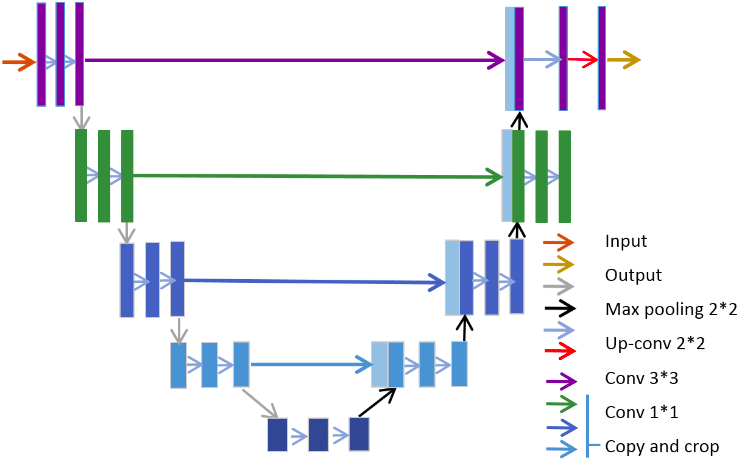

In [ ]:
class Downsample_Block(tf.keras.Model):
    def __init__(self,out_ch,down_sample=True,batch_norm=True):
        super(Downsample_Block, self).__init__()
        self.down_sample = down_sample
        self.batch_norm = batch_norm 
        self.bn = tf.keras.layers.BatchNormalization()
        self.pool = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))
        self.conv1 = tf.keras.layers.Conv2D(filters=out_ch, kernel_size=3,padding="same")
        self.conv2 = tf.keras.layers.Conv2D(filters=out_ch, kernel_size=3,padding="same")
    
    @tf.function
    def call(self,x):
        if self.down_sample:
            x = self.pool(x)
        if self.batch_norm:
            x = self.bn(x)
        x = tf.nn.relu(self.conv1(x))
        x = tf.nn.relu(self.conv2(x))
        return x


class Upsample_Block(tf.keras.Model):
    def __init__(self,out_ch):
        super(Upsample_Block, self).__init__()
        self.upsample = tf.keras.layers.UpSampling2D(size=(2,2),interpolation='bilinear')
        self.bn = tf.keras.layers.BatchNormalization()
        self.conv1 = tf.keras.layers.Conv2D(filters=out_ch,kernel_size=(3,3), padding="same")
        self.conv2 = tf.keras.layers.Conv2D(filters=out_ch,kernel_size=(3,3), padding="same")
    
    @tf.function
    def call(self,x,skip):
        up = self.upsample(x)  #size of image gets doubles..ie (16x16) becomes (32x32)
        out = tf.keras.layers.concatenate([up, skip],axis=-1)
        out = self.bn(out)
        out = tf.nn.relu(self.conv1(out))
        out = tf.nn.relu(self.conv2(out))
        return out


class Unet(tf.keras.Model):
    def __init__(self):
        super(Unet, self).__init__()                                                                   # input          #output
        self.encoder_block1 = Downsample_Block(out_ch=32,down_sample=False,batch_norm=False) #(512,512,3) -> (512,512,32)  
        self.encoder_block2 = Downsample_Block(out_ch=64)  #(512,512,32) -> (256,256,64)
        self.encoder_block3 = Downsample_Block(out_ch=128)  #(256,256,64) -> (128,128,128)
        self.encoder_block4 = Downsample_Block(out_ch=256)  #(128,128,128) -> (64,64,256)
        self.encoder_block5 = Downsample_Block(out_ch=512)  #(64,64,256) -> (32,32,512)
        self.encoder_block6 = Downsample_Block(out_ch=1024) #(32,32,512) -> (16,16,1024)

                                                   # input            skip       output
        self.decoder_block1 = Upsample_Block(512)  # (16,16,1024)    (32,32,512)  (32,32,512)
        self.decoder_block2 = Upsample_Block(256)  # (32,32,512)    (64,64,256)  (64,64,256)
        self.decoder_block3 = Upsample_Block(128)  #(64,64,256)     (128,128,128) (128,128,128)
        self.decoder_block4 = Upsample_Block(64)   #(128,128,128)   (256,256,64)  (256,256,64)
        self.decoder_block5 = Upsample_Block(32)   #(256,256,64)   (512,512,32)  (512,512,32)
        
        self.last_layer = keras.layers.Conv2D(1,kernel_size=3,padding="same")
    
    
    @tf.function
    def call(self,x):
        d1 = self.encoder_block1(x)
        d2 = self.encoder_block2(d1)
        d3 = self.encoder_block3(d2)
        d4 = self.encoder_block4(d3)
        d5 = self.encoder_block5(d4)
        d6 = self.encoder_block6(d5)

        u1 = self.decoder_block1(d6,d5)
        u2 = self.decoder_block2(u1,d4) 
        u3 = self.decoder_block3(u2,d3)
        u4 = self.decoder_block4(u3,d2)
        u5 = self.decoder_block5(u4,d1)

        out = self.last_layer(u5)

        return out

    def summary(self,input_shape=(512,512,3)):
        """ 
        overriding summary function
        """
        x = tf.keras.layers.Input(shape=input_shape)
        model = tf.keras.Model(inputs=[x], outputs=self.call(x))
        return model.summary()

In [ ]:
#test code
model = Unet() 
model.summary(input_shape=(512,512,3))

<a class="anchor" id="section13"></a>
## Training

### About competition metric
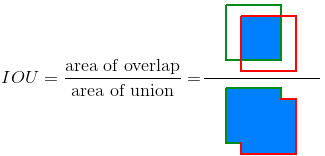

```
This competition is evaluated on the mean average precision at different intersection over union (IoU) thresholds.
Used thresholds = (0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95).

At each threshold value t, a precision value is calculated based on the number of true positives (TP), false negatives (FN), and false positives (FP) resulting from comparing the predicted object to all ground truth objects. Basically it will be pixels.
```


In [ ]:
@tf.function
def iou_calculator(y_pred,y_true):
    """
    computes average iou at various thresholds
    """
    def IoU(y_pred, y_true):
        I = tf.reduce_sum(y_pred * y_true, axis=(1, 2))
        U = tf.reduce_sum(y_pred + y_true, axis=(1, 2)) - I
        return tf.reduce_mean(I / U)
    
    ious = []
    thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
    for thresh in thresholds:
        y_pred_ = tf.cast(tf.math.greater(y_pred,thresh),dtype=tf.float32)
        iou = IoU(y_pred_,y_true)
        ious.append(iou)
    return tf.reduce_mean(ious)


@tf.function
def train_step(x, y):
    '''
    input: x, y <- typically batches 
    return: loss value,iou_value
    '''

    # start the scope of gradient 
    with tf.GradientTape() as tape:
        logits = model(x, training=True) # forward pass

        y_pred_prob = tf.nn.sigmoid(logits)
        y_pred_prob = tf.squeeze(y_pred_prob,axis=-1)
        train_loss_value = bce(y, y_pred_prob) # compute loss 
        train_iou_value = iou_calculator(y, y_pred_prob)

    # compute gradient 
    grads = tape.gradient(train_loss_value, model.trainable_weights)

    # update weights
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    
    return train_loss_value.numpy(),train_iou_value.numpy()


@tf.function
def val_step(X,y):

    # forward pass
    yhat = model(X, training=False)
    
    # calculate loss
    y_pred_prob = tf.nn.sigmoid(yhat)
    y_pred_prob = tf.squeeze(y_pred_prob,axis=-1)
    val_loss_value = bce(y, y_pred_prob) # compute loss 
    val_iou_value = iou_calculator(y, y_pred_prob)
    
    return val_loss_value.numpy(), val_iou_value.numpy()


As of now we will train our model for about 15 epochs and will see the results

In [ ]:
epochs=15
model_weight_dir = './model_weights'
#loss
bce = tf.keras.losses.BinaryCrossentropy()
#optimizer
optimizer = tf.keras.optimizers.Adam()



if not os.path.exists(model_weight_dir):
    os.makedirs(model_weight_dir)

epoch_train_losses,epoch_val_losses = [],[]
epoch_train_ious,epoch_val_ious = [],[]

epoch_loss_min = float('inf')

for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch+1, epochs))
    t = time.time()
    train_loss,train_iou = [],[]
    train_progbar = tf.keras.utils.Progbar(len(train_data))
    for idx,data in enumerate(train_data):
        image,mask = data
        batch_train_loss,batch_train_iou = train_step(image,mask)     
        train_progbar.update(idx+1) 
        train_loss.append(batch_train_loss)
        train_iou.append(batch_train_iou)
    
    val_loss,val_iou = [],[]
    val_progbar = tf.keras.utils.Progbar(len(val_data))
    for idx,data in enumerate(val_data):
        image,mask = data
        batch_val_loss,batch_val_iou = val_step(image,mask)
        val_progbar.update(idx+1)
        val_loss.append(batch_val_loss)
        val_iou.append(batch_val_iou)
       
    epoch_train_loss = np.mean(train_loss)
    epoch_val_loss = np.mean(val_loss)
    epoch_train_iou = np.mean(train_iou)
    epoch_val_iou = np.mean(val_iou)


    epoch_train_losses.append(epoch_train_loss)
    epoch_val_losses.append(epoch_val_loss)
    epoch_train_ious.append(epoch_train_iou)
    epoch_val_ious.append(epoch_val_iou)



    #save model if loss decreases
    if epoch_val_loss < epoch_loss_min:
        print(f'Saving model--Loss decreased from {str(epoch_loss_min)} to {str(epoch_val_loss)}')
        weight_name = 'bestmodel.h5'
        weight_path = os.path.join(model_weight_dir,weight_name)
        model.save_weights(weight_path)
        epoch_loss_min = epoch_val_loss
        
    template = 'ETA: {} \n Train loss: {} Train iou: {} Validation loss:{} Validation iou:{}'
    
    print(template.format(round((time.time() - t)/60, 2),round(epoch_train_loss,4),round(epoch_train_iou,4),round(epoch_val_loss,4),round(epoch_val_iou,4)))

Actually you can train more epochs.For the ease of use iam stopping here.

In [ ]:
#plot
epochs = [i for i in range(15)]
fig,axes = plt.subplots(1,2,figsize=(15,6))
axes[0].plot(epochs,epoch_train_losses,label="train loss")
axes[0].plot(epochs,epoch_val_losses,label="val loss")
axes[1].plot(epochs,epoch_train_ious,label="train iou")
axes[1].plot(epochs,epoch_val_ious,label="val iou")
axes[0].legend()
axes[1].legend()
plt.show()

We know training is not smooth. But as a baseline we can go ahead with this model

<a class="anchor" id="section14"></a>
## Inference

In [ ]:
class Downsample_Block(tf.keras.Model):
    def __init__(self,out_ch,down_sample=True,batch_norm=True):
        super(Downsample_Block, self).__init__()
        self.down_sample = down_sample
        self.batch_norm = batch_norm 
        self.bn = tf.keras.layers.BatchNormalization()
        self.pool = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))
        self.conv1 = tf.keras.layers.Conv2D(filters=out_ch, kernel_size=3,padding="same")
        self.conv2 = tf.keras.layers.Conv2D(filters=out_ch, kernel_size=3,padding="same")
    
    @tf.function
    def call(self,x):
        if self.down_sample:
            x = self.pool(x)
        if self.batch_norm:
            x = self.bn(x)
        x = tf.nn.relu(self.conv1(x))
        x = tf.nn.relu(self.conv2(x))
        return x


class Upsample_Block(tf.keras.Model):
    def __init__(self,out_ch):
        super(Upsample_Block, self).__init__()
        self.upsample = tf.keras.layers.UpSampling2D(size=(2,2),interpolation='bilinear')
        self.bn = tf.keras.layers.BatchNormalization()
        self.conv1 = tf.keras.layers.Conv2D(filters=out_ch,kernel_size=(3,3), padding="same")
        self.conv2 = tf.keras.layers.Conv2D(filters=out_ch,kernel_size=(3,3), padding="same")
    
    @tf.function
    def call(self,x,skip):
        up = self.upsample(x)  #size of image gets doubles..ie (16x16) becomes (32x32)
        out = tf.keras.layers.concatenate([up, skip],axis=-1)
        out = self.bn(out)
        out = tf.nn.relu(self.conv1(out))
        out = tf.nn.relu(self.conv2(out))
        return out


class Unet(tf.keras.Model):
    def __init__(self):
        super(Unet, self).__init__()                                                                   # input          #output
        self.encoder_block1 = Downsample_Block(out_ch=32,down_sample=False,batch_norm=False) #(512,512,3) -> (512,512,32)  
        self.encoder_block2 = Downsample_Block(out_ch=64)  #(512,512,32) -> (256,256,64)
        self.encoder_block3 = Downsample_Block(out_ch=128)  #(256,256,64) -> (128,128,128)
        self.encoder_block4 = Downsample_Block(out_ch=256)  #(128,128,128) -> (64,64,256)
        self.encoder_block5 = Downsample_Block(out_ch=512)  #(64,64,256) -> (32,32,512)
        self.encoder_block6 = Downsample_Block(out_ch=1024) #(32,32,512) -> (16,16,1024)

                                                   # input            skip       output
        self.decoder_block1 = Upsample_Block(512)  # (16,16,1024)    (32,32,512)  (32,32,512)
        self.decoder_block2 = Upsample_Block(256)  # (32,32,512)    (64,64,256)  (64,64,256)
        self.decoder_block3 = Upsample_Block(128)  #(64,64,256)     (128,128,128) (128,128,128)
        self.decoder_block4 = Upsample_Block(64)   #(128,128,128)   (256,256,64)  (256,256,64)
        self.decoder_block5 = Upsample_Block(32)   #(256,256,64)   (512,512,32)  (512,512,32)
        
        self.last_layer = keras.layers.Conv2D(1,kernel_size=3,padding="same")
    
    
    @tf.function
    def call(self,x):
        d1 = self.encoder_block1(x)
        d2 = self.encoder_block2(d1)
        d3 = self.encoder_block3(d2)
        d4 = self.encoder_block4(d3)
        d5 = self.encoder_block5(d4)
        d6 = self.encoder_block6(d5)

        u1 = self.decoder_block1(d6,d5)
        u2 = self.decoder_block2(u1,d4) 
        u3 = self.decoder_block3(u2,d3)
        u4 = self.decoder_block4(u3,d2)
        u5 = self.decoder_block5(u4,d1)

        out = self.last_layer(u5)

        return out

    def summary(self,input_shape=(512,512,3)):
        """ 
        overriding summary function
        """
        x = tf.keras.layers.Input(shape=input_shape)
        model = tf.keras.Model(inputs=[x], outputs=self.call(x))
        return model.summary()

In [ ]:
#load weights

model = Unet()
x = tf.keras.layers.Input(shape=(512,512,3))
model = tf.keras.Model(inputs=[x], outputs=model.call(x))

# model.built = True
model.load_weights('./model_weights/bestmodel.h5')

### visualizing train images

In [ ]:
#train infernce
thresh = 0.5
iter_ = train_data.as_numpy_iterator()
images,masks = next(iter_)
out_mask = np.squeeze(tf.nn.sigmoid(model.predict(images)))
out_mask = tf.cast(tf.math.greater(out_mask,thresh),dtype=tf.float32)
for i in range(len(images)):
    image = images[i]
    mask = masks[i]
    mask_pred = out_mask[i]
    fig,axes = plt.subplots(1,3,figsize=(10,20))
    axes[0].imshow(image)
    axes[0].set_title('Image')
    axes[1].imshow(mask,cmap="gray")
    axes[1].set_title('Mask')
    axes[2].imshow(mask_pred,cmap='gray')
    axes[2].set_title('Predicted mask')

## visualizing validation images

In [ ]:
#validation infernce
thresh = 0.5
iter_ = val_data.as_numpy_iterator()
images,masks = next(iter_)
out_mask = np.squeeze(tf.nn.sigmoid(model.predict(images)))
out_mask = tf.cast(tf.math.greater(out_mask,thresh),dtype=tf.float32)

for i in range(len(images)):
    image = images[i]
    mask = masks[i]
    mask_pred = out_mask[i]
    fig,axes = plt.subplots(1,3,figsize=(10,20))
    axes[0].imshow(image)
    axes[0].set_title('Image')
    axes[1].imshow(mask,cmap="gray")
    axes[1].set_title('Mask')
    axes[2].imshow(mask_pred,cmap='gray')
    axes[2].set_title('Predicted mask')

### visualizing test images

In [ ]:
def load_and_predict(img_path,thresh=0.5):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(512,512))
    img = img/255.0
    img = tf.cast(img,dtype=tf.float32)
    img = tf.expand_dims(img,axis=0)
    
    #predict
    out_mask = np.squeeze(tf.nn.sigmoid(model.predict(img)))
    if thresh:
        out_mask = tf.cast(tf.math.greater(out_mask,thresh),dtype=tf.float32)
    return out_mask

In [ ]:
TEST_DIR_PATH = '../input/sartorius-cell-instance-segmentation/test'
for img_name in os.listdir(TEST_DIR_PATH):
    
    img_path = os.path.join(TEST_DIR_PATH,img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(512,512))
    
    mask = load_and_predict(img_path,thresh=0.5)
    fig,axes = plt.subplots(1,2,figsize=(10,20))
    axes[0].imshow(img)
    axes[0].set_title('Image')
    axes[1].imshow(mask,cmap="gray")
    axes[1].set_title('Predicted Mask')
    plt.show()

<a class="anchor" id="section15"></a>
## Test Image Prediction and submission

You can refer my [prediction](http://https://www.kaggle.com/arunmohan003/inference-cell-segmentation-baseline-unet) kernel for a baseline submission

